In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
!{sys.executable} -m pip install quantities

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xlsxwriter

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
from random import sample

import pickle as pkl
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import seaborn as sns
#__________________________________

#read in file from spike
def read_data(filename, separator, colums, nrows = None):
    data = pd.read_csv(filename, sep=separator, nrows=nrows)
    data.colums = colums
    return data

def get_spike_count_under_mechanical_stimulus(fibers, start_level, level_range, mech_stimulus, time_window = 16, level = 10):
    
    #fibers = recording.actpots
    level_spikes = {}
    
    for i in range(level):
        
        end_level = start_level + level_range
        fiber_list = []
        
        for fiber in fibers:
            if fiber.onset >= start_level and fiber.onset < end_level:
                fiber_list.append(fiber)
            if fiber.onset > end_level:
                break
            level_spikes[i] = fiber_list
            
        start_level = end_level
        
    return level_spikes

#__________________________________

def calc_train(idx):
    train = []
    for i, k in times_wrt_stml:
        if(k == idx):
            train.append(i)
    return train

def calc_train_start(idx):
    train = []
    for i, k in times_wrt_start:
        if(k == idx):
            train.append(i)
    return train

def find_shortest_list(lists):
    min_i = len(lists[0])
    for l in lists:
        if(len(l) < min_i):
            min_i = len(l)
    return min_i

#spike train timings
def calc_train_timings(train):
    train_timings = []
    for i in range(len(train)-1):
        #print(i)
        train_timings.append(train[i+1]/train[i])
    return train_timings

#calculate average timings
def calc_avg_train_timings(trains, length):
    avg_timings = []
    if(length < 5):
        length = 5
    for i in range(length):
        avg_timing_sum = 0
        for j in range(len(trains)):
            avg_timing_sum += trains[j][i]
        avg_timings.append(avg_timing_sum/len(trains))
    return avg_timings

#cut short spike trains
def cut_short_trains(trains):
    long_trains = []
    for i in range(len(trains)):
        if(len(trains[i]) < 5):
            continue
        long_trains.append(trains[i])
    return long_trains

# calculate ISIs
def calc_isi(train):
    single_isi = []
    for i in range(len(train) - 1):
        single_isi.append(train[i + 1]  - train[i])
    return single_isi
        
def plot_spike_train_timing(length, spike_timings, train_number):
    # Data for plotting
    spikes = np.arange(0, length, 1)

    fig, ax = plt.subplots()
    ax.plot(spikes, spike_timings, '-o')
    
    ax.set(xlabel='spike', ylabel='distance',
       title='Spike Train '+ str(train_number))
    plt.grid(True)

    #fig.savefig("spike_train_0.png")
    plt.show()
    
def plot_isi(length, isi, log_isi, train_number):
    # Data for plotting
    spikes = np.arange(0, length, 1)
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(spikes, isi[i], 'g-o')
    ax1.set(xlabel='spike',
       title='isi '+ str(train_number))# + "R2: " + r2_isi[i])
    ax2.plot(spikes, log_isi[i], 'b-o')
    ax2.set(xlabel='spike',
       title='log(isi) '+ str(train_number))# + "R2: " + r2_log_isi[i])
    
    #for ax in fig.get_axes():
    #    ax.label_outer()
    fig.set_size_inches(12, 4)

    plt.show()

In [5]:
ex_date = "11_12_13"
ex_number = "U1b"
ex_file_name = ex_date + ex_number

# Load from pkl file

In [ ]:
recording_neo = pkl.load(open("results/recording_neo_" + ex_file_name + ".pkl", "rb"))
recording = pkl.load(open("results/recording_" + ex_file_name + ".pkl", "rb"))
spike_trains = pkl.load(open("results/spike_trains_" + ex_file_name + ".pkl", "rb"))

# Import spike2 file via neo importer

In [6]:
from pathlib import Path
import neo
import neo_importers.neo_spike_importer as spike_importer
from neo_importers.neo_wrapper import MNGRecording
from features import FeatureDatabase

file_name = Path("..")/".."/"data"/"mechanical data"/ex_date/"11_12_13U1b.smr" #/"Fixed"

# maybe we could make the spike importer return a recording object immediately?
# or recording + block representation?
bl, id_map = spike_importer.import_spike_file(file_name, 
                                      stimuli_event_channels={"DigMark"}, #mechanical_stimuli_from_raw={("Force", 0.003)},
                                      action_potential_channels= "all"
                                      )
seg: neo.core.Segment = bl.segments[0]
recording_neo = MNGRecording(bl.segments[0])

print("There are the following channels in this recording: " + str(recording_neo.all_channels.keys()))

Units "°C" can not be converted to a quantity. Using dimensionless instead
Units "°C" can not be converted to a quantity. Using dimensionless instead


There are the following channels in this recording: dict_keys(['rd.1', 'rd.0', 'rd.2', 'es.0', 'ap.0', 'ap.1', 'ap.2', 'ap.3', 'ap.4', 'ap.5', 'ap.6', 'ap.7'])


In [7]:
#create two lists from es
#one for mechanical stims
mech_stims_temp = []
el_stims_temp = []
next_el = False
el_stims_freq = []
cutoff = 0

#iterate over es.0 to separate electrical and mechanical events
for i in range(len(recording_neo.electrical_stimulus_channels["es.0"])):
    #event is an electrical event
    if next_el == True:
        #append frequency of electrical stimulus to frequency list
        if(recording_neo.electrical_stimulus_channels["es.0"][i].time > cutoff):
            el_stims_freq.append(round(1/recording_neo.electrical_stimulus_channels["es.0"][i-2].interval, 1))
        #append electrical stimulus to el_stim list
        el_stims_temp.append(recording_neo.electrical_stimulus_channels["es.0"][i])
        next_el = False
    #event is a mechanical event
    if recording_neo.electrical_stimulus_channels["es.0"][i].interval < 0.1:
        mech_stims_temp.append(recording_neo.electrical_stimulus_channels["es.0"][i])
        next_el = True

In [8]:
el_stims = []
mech_stims = []
for e in el_stims_temp:
    if(e.time > cutoff):
        #print(type(e.time))
        #e.time -= cutoff
        el_stims.append(e)
        
for m in mech_stims_temp:
    if(m.time > cutoff):
        #m.time -= cutoff
        mech_stims.append(m)
        
#append frequencies to the electrical stimuli
for i in range(len(el_stims)):
    el_stims[i].frequency = el_stims_freq[i]

# continue with old framework

In [10]:
%load_ext autoreload
%autoreload 2
from gui import SpikeImportGUI
from importers import SpikeImporter
from recordings import MNGRecording

# present the Spike GUI and let the user make his choices
spike_gui = SpikeImportGUI()

importer = SpikeImporter(filepath = spike_gui.filepath, time_channel = spike_gui.time_channel, signal_channel = spike_gui.signal_channel)
    
recording = MNGRecording.from_importer(importer = importer, stimulus_channels = spike_gui.stimulus_channels, \
                                      ap_channels = spike_gui.ap_channels, force_threshold = spike_gui.force_threshold, \
                                      max_ap_gap_time = spike_gui.max_ap_gap)

List of eletrical stimuli created.
List of mechanical stimuli created.
Finished processing AP channel 1 out of 1
List of APs created.
Done with cropping the intervals


In [11]:
# load file for mechanical stimulus recognition
df = read_data(spike_gui.filepath, ",", ["Time", "32 DigMark", "4 nw-1", "3 Force", "1 Signal"])
print('Biggest thing passed')

Biggest thing passed


<ipython-input-4-5593bbe1f2bf>:19: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.colums = colums


In [14]:
fibers = recording.actpots #df.loc[df["5 nw-1"] == 1].values.tolist() # recording.actpots
mechanical_stims = recording.el_stimuli #df.loc[df["32 DigMark"]].values.tolist() #recording.el_stimuli

m_signals = []
for m_time in mechanical_stims:
    #start_idx = df[ df['Time'] == m_time].index.values[0]
    start_index = int(m_time.timepoint/0.00005)
    #end_idx = df[ df['Time'] == m_time + 0.5].index.values[0]
    end_index = int(start_index + 10000)
    signal = df[start_index:end_index]['3 Force'].values
    m_signals.append(signal[0::10])
    
print('Signals extracted')

#___________________________________

time_window = 0.5
level = 50
level_range = time_window / level
freq_list = []

for k, mech_st in enumerate(mechanical_stims):
    
    index_start = mech_st.timepoint/0.00005 #df[df["Time"] == round(mech_st, 5)].index.values
    index_end = index_start + 10000 #df[df["Time"] == round(mech_st + time_window, 5)].index.values

    start_level = mech_st.timepoint
    
    freq_list.append(get_spike_count_under_mechanical_stimulus(fibers, start_level, level_range, mech_st, time_window = time_window, level = level))
    
print('freq_list created')    
#___________________________________

rows = len(freq_list)
colums = len(freq_list[0])
counts = np.zeros((rows, colums))

for i in range(rows):
    for j in range(colums):
        counts[i, j] += len(freq_list[i][j])
        
print('counts created')
#___________________________________

times_wrt_stml = []
times_wrt_start = []

for mech_st_id in range(len(freq_list)):
    for level in freq_list[mech_st_id]:
        for value in freq_list[mech_st_id][level]:
            times_wrt_start.append([value.onset, mech_st_id])
            times_wrt_stml.append([value.onset - mechanical_stims[mech_st_id].timepoint, mech_st_id])

print('times_wrt_stml and times_wrt_start created')
#___________________________________

sum2 = len(times_wrt_start)
avg2 = sum2/len(counts)
print("average spikes: ", avg2)
#___________________________________

mech_forces = m_signals

#data = {}
#data['counts'] = counts
#data['mech_forces'] = mech_forces
#data['times_wrt_stml'] = times_wrt_stml
#data['times_wrt_start'] = times_wrt_start
#pkl.dump(data, open("data_11_10_27U2a.pkl", "wb"))

#print('Data stored in data')#_11_10_27U2a.pkl')

Signals extracted
freq_list created
counts created
times_wrt_stml and times_wrt_start created
average spikes:  23.0


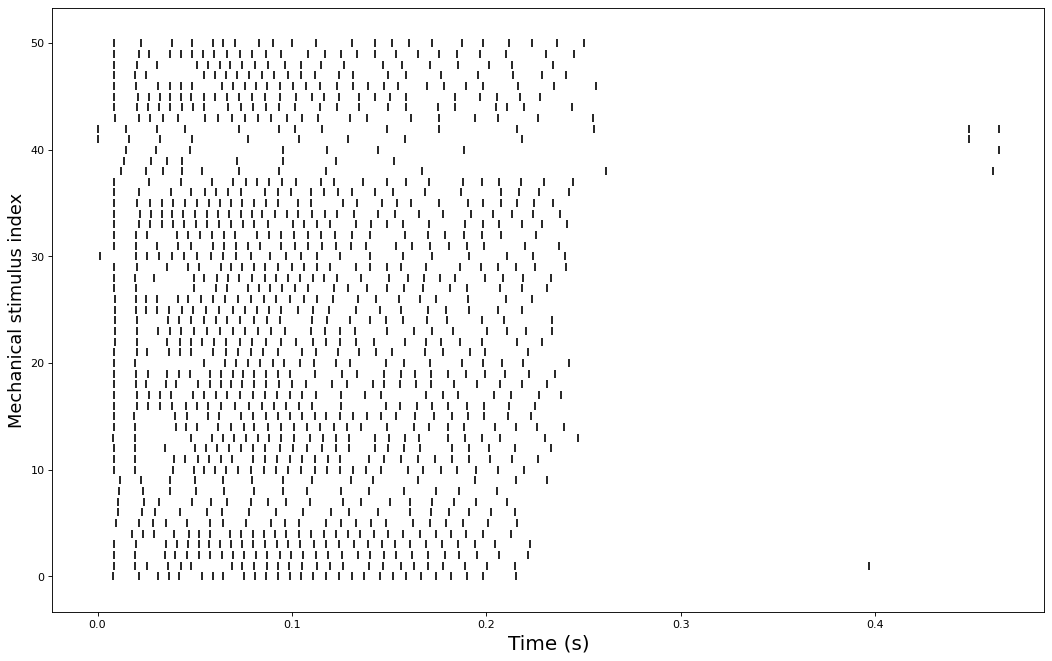

In [44]:
times_separated = [[] for i in range(len(counts))]
current_idx = 0

for time in times_wrt_stml:
    
    idx = time[-1]
    if current_idx != idx:
        current_idx = idx
        
    times_separated[current_idx].append(time[0])
    
# _____________________________________________________________________________ #

fig =figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
_ = plt.eventplot(times_separated, linelengths=0.75, color='black')

plt.xlabel('Time (s)', fontsize=18)
_ = plt.ylabel('Mechanical stimulus index', fontsize=16)
fig.savefig(ex_file_name + "_event.png")

<ipython-input-4-5593bbe1f2bf>:71: RuntimeWarning: divide by zero encountered in double_scalars
  train_timings.append(train[i+1]/train[i])


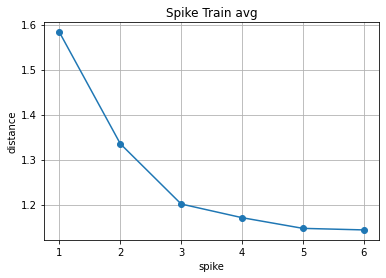

51


In [17]:
trains = []
for i in range(len(counts)):
    train = calc_train(i)
    spike_timings = calc_train_timings(train)
    trains.append(spike_timings)
    #plot_spike_train_timing(len(train)-1, spike_timings, i)
min_length = find_shortest_list(trains)
if(min_length < 5):
    min_length = 5
long_trains = cut_short_trains(trains)
avg_spike_timings = calc_avg_train_timings(long_trains, min_length)
plot_spike_train_timing(min_length, avg_spike_timings, 'avg')
print(len(long_trains))

In [18]:
spike_counts = []
spike_counts_total = 0
for i in range(len(counts)):
    sum_ = 0
    for i, val in enumerate(counts[i]):
        sum_ += val
    spike_counts.append(sum_)
    spike_counts_total += sum_
print(len(spike_counts))
print(spike_counts_total)

51
1173.0


# calculate the excel table

In [19]:
import math
import copy

# calculate mech durations
for m in recording.mech_stimuli:
    m.duration = m.offset - m.onset
    
num_trains = len(mech_stims)

#calculate time to next mech stim
for i in range(num_trains-1):
    #print(i)
    recording.mech_stimuli[i].next_stim = recording.mech_stimuli[i+1].onset-recording.mech_stimuli[i].onset

#calculate time to next stim
for m in range(len(recording.mech_stimuli)-1):
    #print(i)
    recording.mech_stimuli[m].next_stim = recording.mech_stimuli[m + 1].onset - recording.mech_stimuli[m].onset
    
#calculate spike train times
spike_train_times = []
for i in range(num_trains):
    #print(i)
    spike_train_times.append(calc_train_start(i))
    
#calculate spike train durations
spike_train_duration = []
#print(len(spike_train_times))
for i in range(len(spike_counts)):
    if(spike_counts[i] > 0):
        #print(i)
        spike_train_duration.append(spike_train_times[i][int(spike_counts[i])-1] - spike_train_times[i][0])
    else:
        spike_train_duration.append(0)

#calculate isi
isi = []
for i in range(len(spike_train_times)):
    isi.append(calc_isi(spike_train_times[i]))
    
#calculate r2 for isi
#r2_isi = []
#mse_isi = []
#for i in isi:
#    length = len(i)
#    spikes = np.arange(1, length+1, 1)
#    r2_isi.append(r2_score(spikes, i))
#    mse_isi.append(mean_squared_error(spikes,i))

# calculate log(isi)
log_isi = copy.deepcopy(isi)
for i in range(len(isi)):
    for j in range(len(isi[i])):
        log_isi[i][j] = math.log(log_isi[i][j], 10)
        
#calculate r2 for log(isi)
#r2_log_isi = []
#mse_log_isi = []
#for i in log_isi:
#    length = len(i)
#    spikes = np.arange(1, length+1, 1)
#    r2_log_isi.append(r2_score(spikes, i))
#    mse_log_isi.append(mean_squared_error(spikes,i))
        
#calculate instantaneous frequency
inst_freq = copy.deepcopy(isi)
for i in range(len(isi)):
    for j in range(len(isi[i])):
        inst_freq[i][j] = 1/inst_freq[i][j]
        
# calculate the peak firing frequency (sliding window)
peak_firing_freq_sw = []
for i in range(len(inst_freq)):
    if(len(inst_freq[i]) < 5):
        peak_firing_freq_sw.append(1)
    else:
        peak_firing_freq_sw.append(max((np.convolve(inst_freq[i], np.ones(5)/5, mode = 'valid'))))
    
# calculate the peak firing frequenciy (5 highest instantaneous frequencies)
peak_firing_freq_if = []
for i in range(len(inst_freq)):
    if(len(inst_freq[i]) == 0):
        peak_firing_freq_if.append(0)
    elif(len(inst_freq[i]) < 5):
        peak_firing_freq_if.append(np.mean(inst_freq[i]))
    else:
        peak_firing_freq_if.append(np.mean(sorted(inst_freq[i], reverse=True)[:5]))
        
#calculate mean firing rates
mean_firing_rate = []
for i in range(len(spike_train_duration)):
    if(spike_train_duration[i] > 0):
        mean_firing_rate.append(spike_counts[i]/spike_train_duration[i])
    else:
        mean_firing_rate.append(0)

print(mean_firing_rate)
max_spikes = int(max(spike_counts))
print("Ich habe fertig.")

[135.2003862868014, 66.8982374887458, 136.05442176875357, 135.38748832866148, 143.92187098437043, 106.74429888398204, 88.04108584007953, 90.02250562643167, 72.0906282182807, 63.752276867059905, 123.16437707248471, 119.21137093098721, 111.03708638674843, 104.5150501672317, 112.35955056195957, 121.24038237354614, 119.81566820271074, 113.16648530991183, 121.13055181709193, 119.02137976635856, 89.64781216667257, 108.26076723935563, 113.58473421148614, 111.23470522832643, 102.19951121972433, 119.24636298605226, 116.41443538993708, 98.76543209880737, 115.55555555536871, 111.87607573155977, 96.21418113360016, 109.2657342657989, 115.28706479143949, 120.01714530653823, 126.25163256428777, 123.83900928800222, 98.24861170415615, 93.18085556964286, 24.51253481891567, 57.533261416851694, 17.821341055865584, 22.318937618616328, 30.182170960433737, 89.55831467574052, 106.04453870633517, 123.20328542151232, 108.76132930489369, 94.62365591394888, 93.02325581411539, 110.00634651950794, 90.96547446751715

In [20]:
r2test_isi = []
for i in isi:
    length = len(i)
    spikes = np.arange(1, length+1, 1)
    #mse_isi.append(mean_squared_error(spikes,i))
    #mean_isi = np.mean(i)
    #mean_isi_a = np.arrange(mean_isi, length+1, 0)
    #print(mean_isi_a)
    sqr = np.square(np.subtract(spikes,i))
    sqt = np.square(np.subtract(spikes,np.mean(i)))
    r2test_isi.append(1-(sqr/sqt))

In [22]:
#create spike trains object for storage with pickle
spike_trains = {}
spike_trains['el_stims'] = el_stims
spike_trains['mech_stims'] = mech_stims
spike_trains['mech_forces'] = m_signals
spike_trains['freq_list'] = freq_list
spike_trains['counts'] = counts
spike_trains['mech_forces'] = mech_forces
spike_trains['times_wrt_stml'] = times_wrt_stml
spike_trains['times_wrt_start'] = times_wrt_start
spike_trains['times_separated'] = times_separated
spike_trains['isd'] = trains
spike_trains['spike_counts'] = spike_counts
spike_trains['times'] = spike_train_times
spike_trains['duration'] = spike_train_duration
spike_trains['isi'] = isi
#spike_trains['r2_isi'] = r2_isi
spike_trains['log_isi'] = log_isi
#spike_trains['r2_log_isi'] = r2_log_isi
spike_trains['inst_freq'] = inst_freq
spike_trains['pff_sw'] = peak_firing_freq_sw
spike_trains['pff_max'] = peak_firing_freq_if
spike_trains['mean_firing_rate'] = mean_firing_rate

In [24]:
#save objects with pickle
pkl.dump(recording_neo, open("recording_neo_" + ex_file_name + ".pkl", "wb"))
pkl.dump(recording, open("recording_" + ex_file_name + ".pkl", "wb"))
pkl.dump(spike_trains, open("spike_trains_" + ex_file_name + ".pkl", "wb"))

In [25]:
# info about the current file for data overview
def Average(lst):
    return sum(lst)/len(lst)

total_spikes = len(recording.actpots)
mech_duration = []
for m in recording.mech_stimuli:
    mech_duration.append(m.duration)
print("number of spike trains: " + str(len(spike_counts)))
print("avg spikes: " + str(Average(spike_counts)))
print("avg duration of stimulation: " + str(Average(mech_duration)))
print("avg duration of spike train: " + str(Average(spike_train_duration)))
print("total spikes: " + str(total_spikes))
print("spikes in trains: " + str(sum(spike_counts)))
print("% of spikes in trains: " + str(sum(spike_counts)/total_spikes))

number of spike trains: 51
avg spikes: 23.0
avg duration of stimulation: 0.21304215686277464
avg duration of spike train: 0.24268333333331418
total spikes: 15284
spikes in trains: 1173.0
% of spikes in trains: 0.07674692488877258


In [26]:
#count different electrical fequencies

el_freqs = []
for e in el_stims:
    el_freqs.append(e.frequency.item())
    #print(value(e.frequency))
    
mech_times = []
for m in mech_stims:
    mech_times.append(m.time)


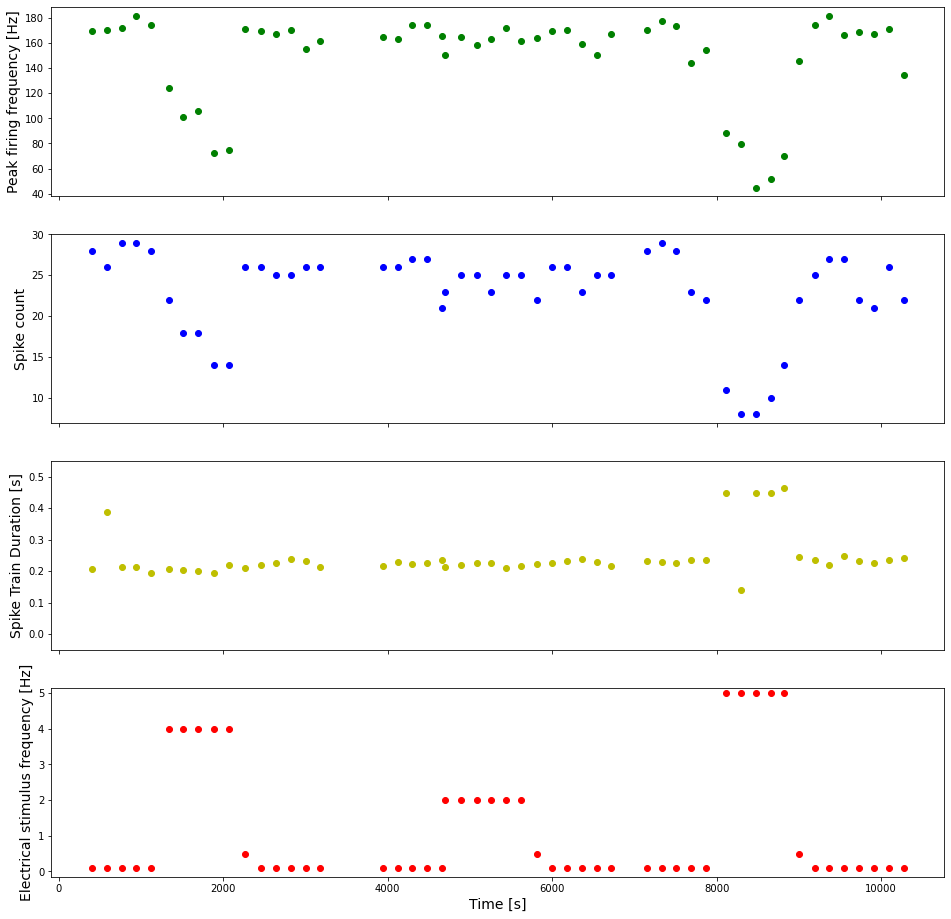

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex = True)
ax1.plot(mech_times, peak_firing_freq_sw, 'go')
ax1.set_ylabel('Peak firing frequency [Hz]', fontsize = 14)
ax2.plot(mech_times, spike_counts, 'bo')
ax2.set_ylabel('Spike count', fontsize = 14)
ax3.plot(mech_times, spike_train_duration, 'yo')#, ylim=(0,0.5))
ax3.set_ylim(-0.05, 0.55)
ax3.set_ylabel('Spike Train Duration [s]', fontsize = 14)
ax4.plot(mech_times, el_freqs, 'ro')
ax4.set_ylim(-0.15, 5.15)
ax4.set_ylabel('Electrical stimulus frequency [Hz]', fontsize = 14)
ax4.set_xlabel('Time [s]', fontsize = 14)

fig.set_size_inches(16, 16)

for ax in fig.get_axes():
    ax.label_outer()
    
fig.savefig(ex_file_name + "pff_sc_s_16_16.png")

<AxesSubplot:label='20879325-0233-43d2-9a19-4bf4adbf6c2f', ylabel='Electrical stimulus frequency [1/s]'>

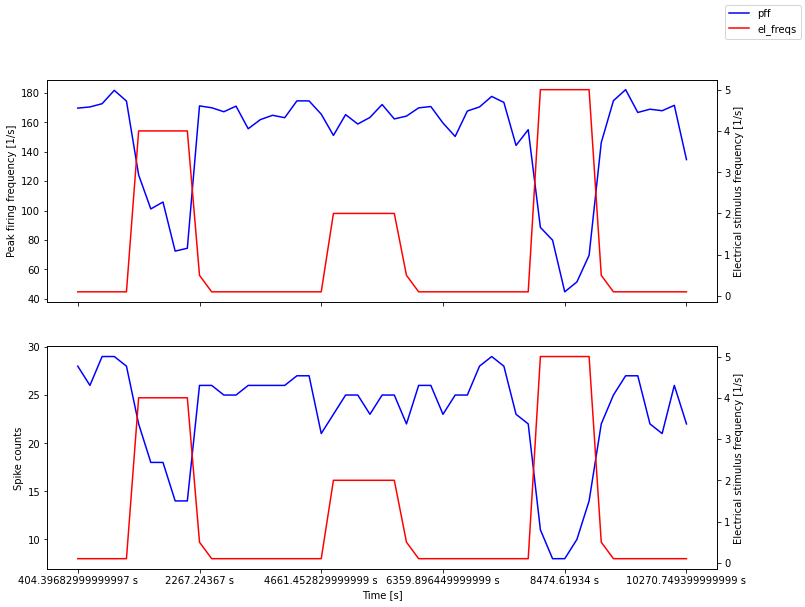

In [28]:
#fig, (ax, ax3) = dfdia.subplots(3, sharex = True)
#df = pd.DataFrame({"foo":[4,5,6], "bar":[1,4,2]})
dfdi = pd.DataFrame({"Time [s]": mech_times,
                     "pff": peak_firing_freq_sw,
                     "sc": spike_counts,
                     "el_freqs": el_freqs})

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))#, sharex=True)

dfdi.plot(x="Time [s]", y="pff", ax=ax1, color="b", ylabel="Peak firing frequency [1/s]", legend=False)#, ylim=(0, max(peak_firing_freq_sw)))
axtest =ax1.twinx()
dfdi.el_freqs.plot(ax=axtest, color="r", ylabel="Electrical stimulus frequency [1/s]")#, ylim=(0, max_spikes))
ax1.figure.legend()
dfdi.plot(x="Time [s]", y="sc", ax=ax2, color="b", ylabel="Spike counts", legend=False)#, ylim=(0, max(peak_firing_freq_sw)))
#dfdi.plot(kind="scatter", ax=ax2, color="b", x="Time [s]", y="sc", xlabel=mech_times, rot=-90)
axtest2 =ax2.twinx()
dfdi.el_freqs.plot(ax=axtest2, color="r", ylabel="Electrical stimulus frequency [1/s]")#, ylim=(0, max_spikes))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


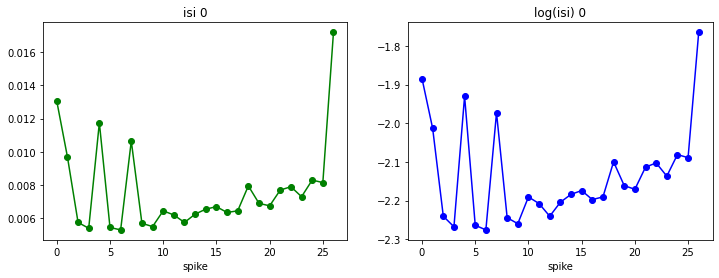

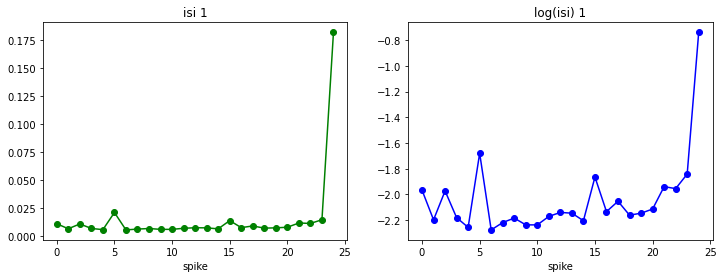

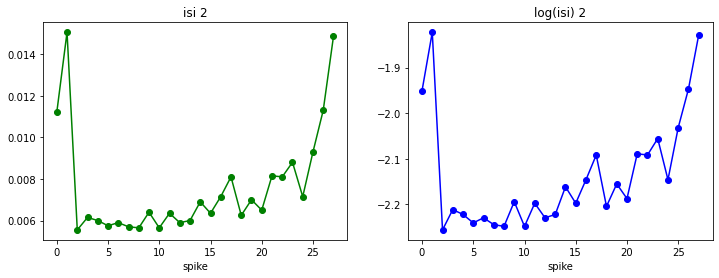

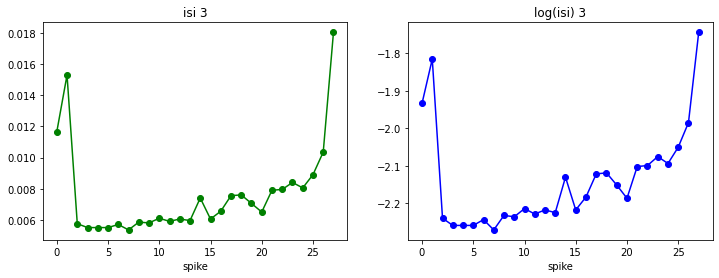

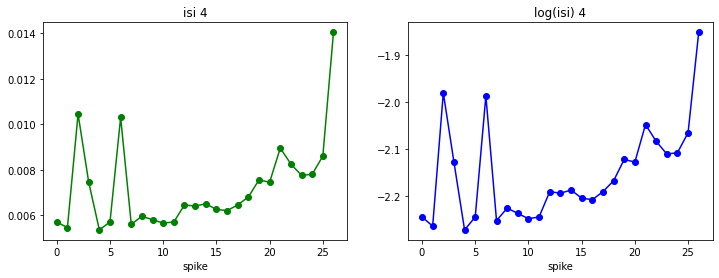

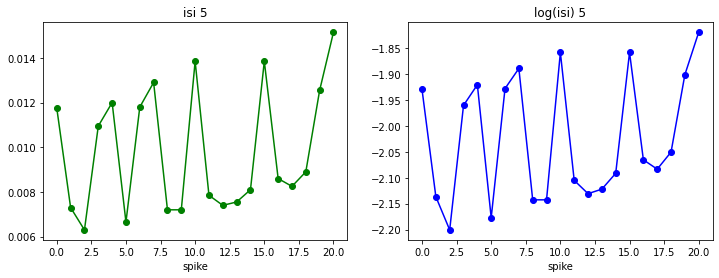

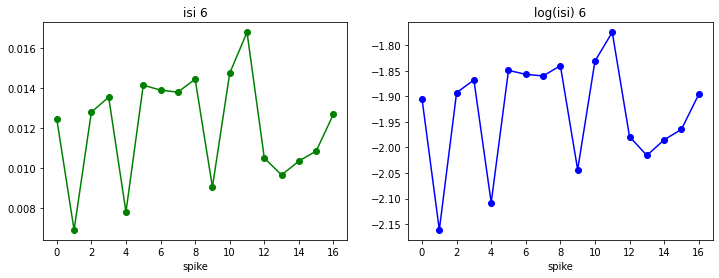

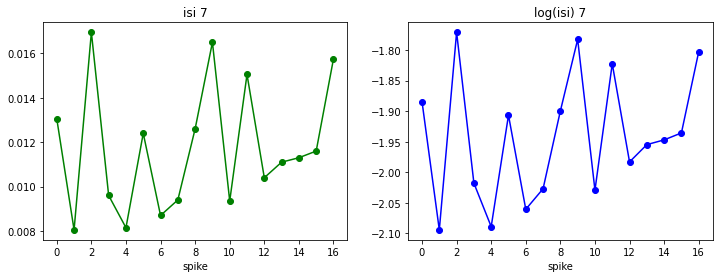

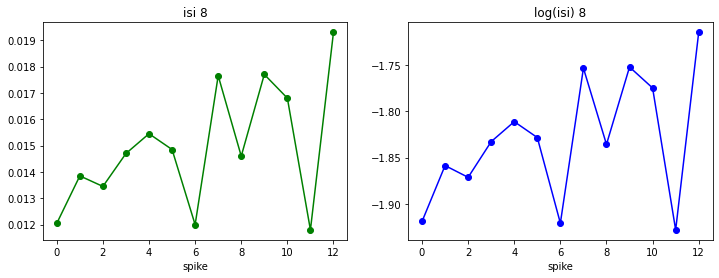

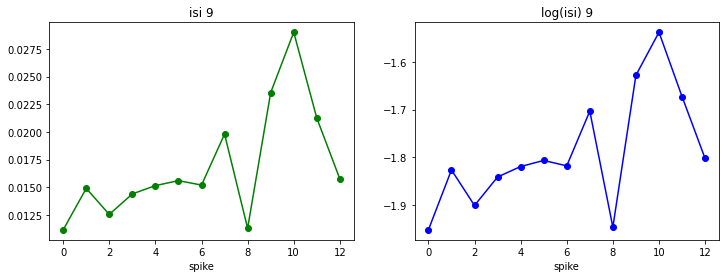

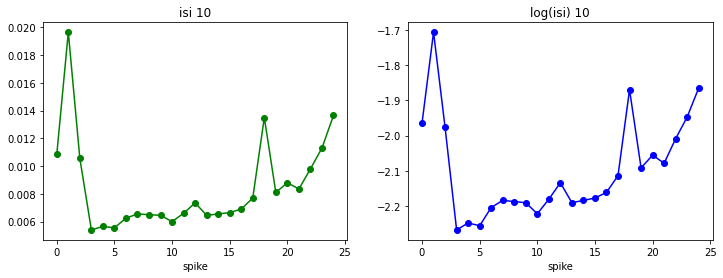

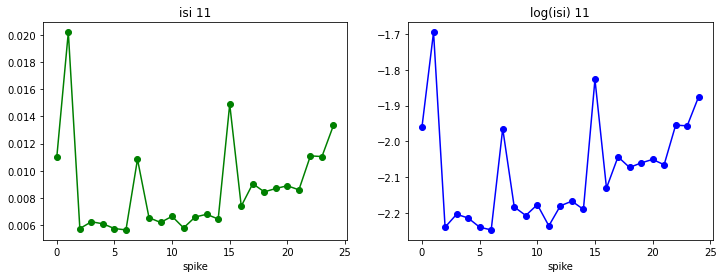

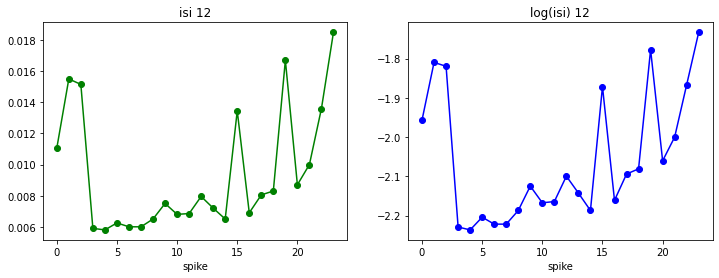

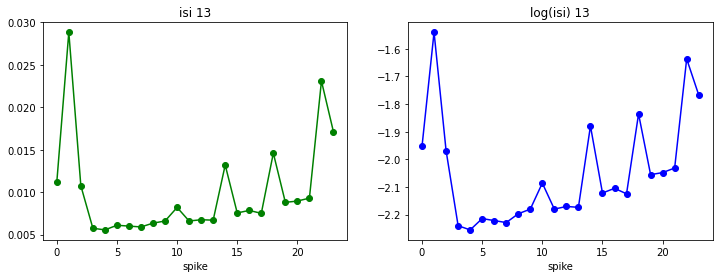

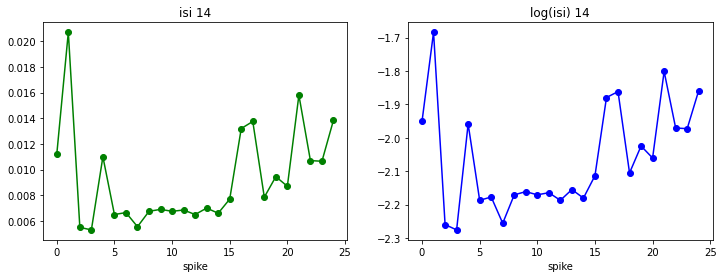

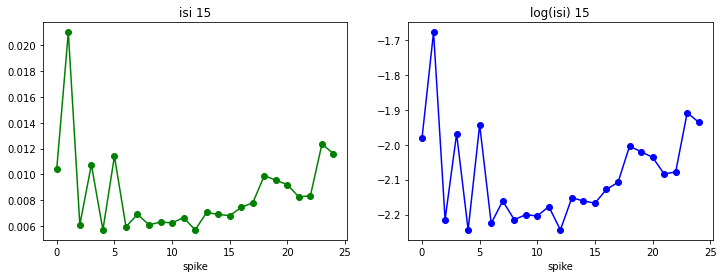

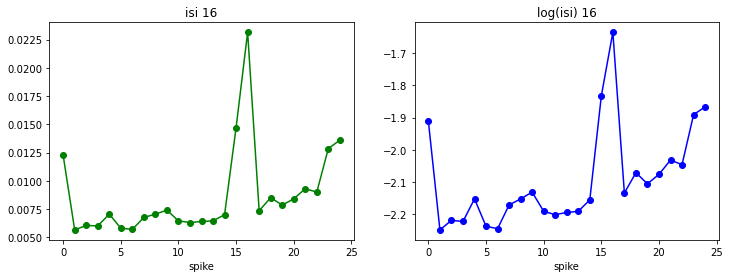

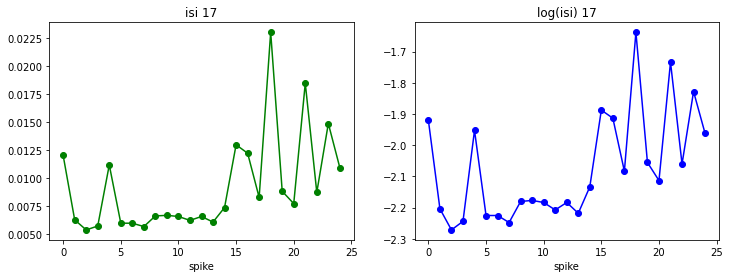

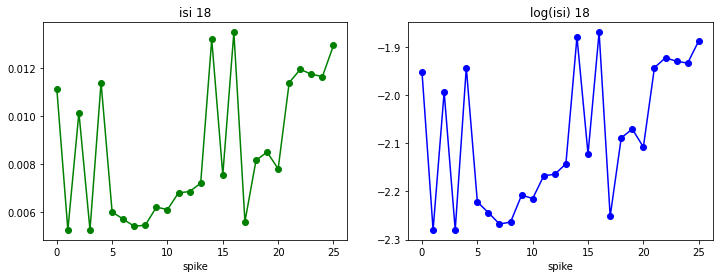

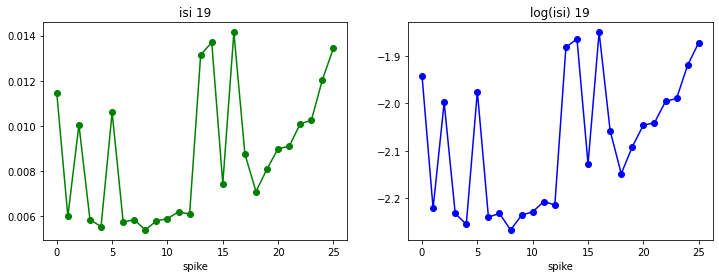

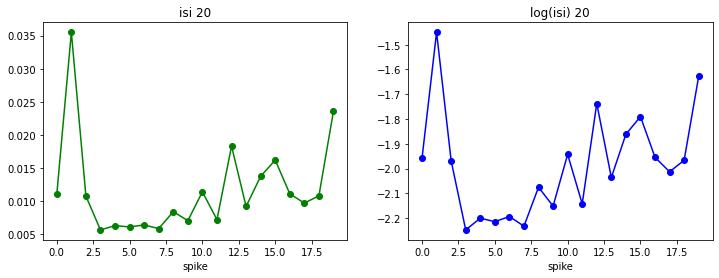

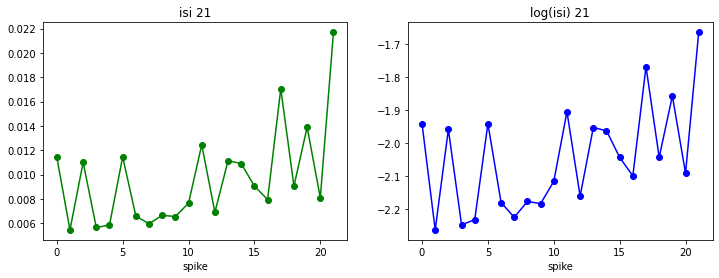

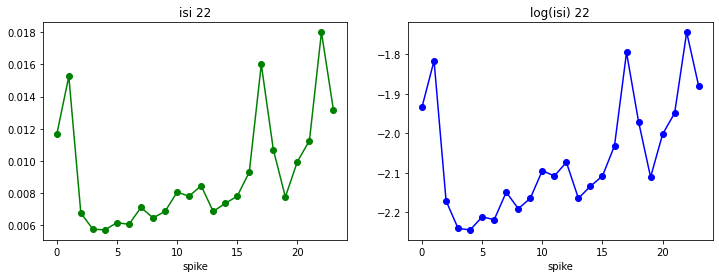

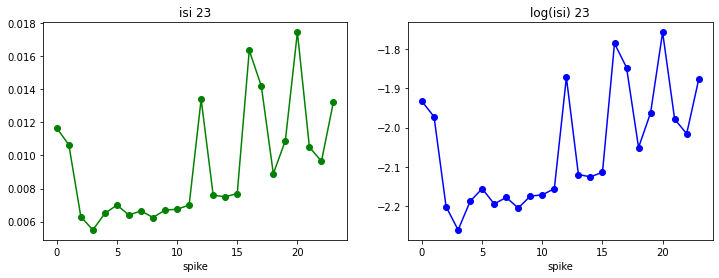

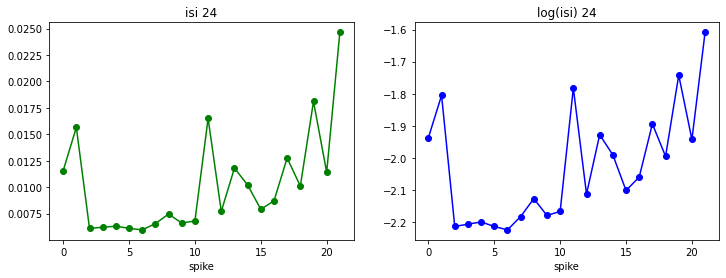

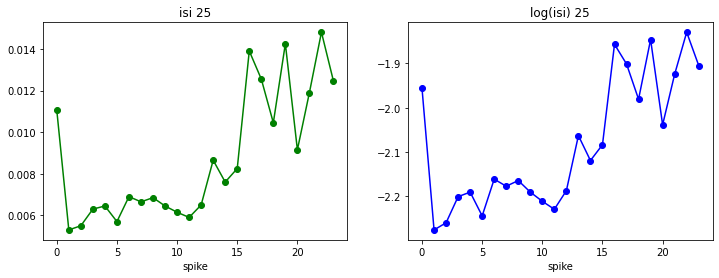

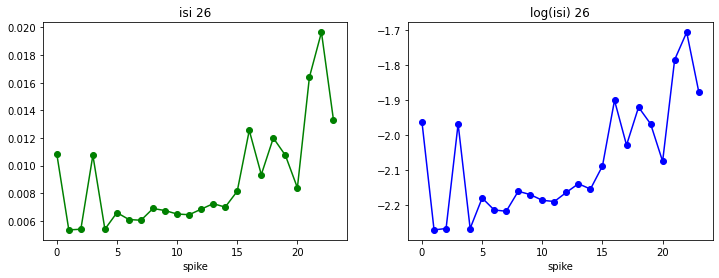

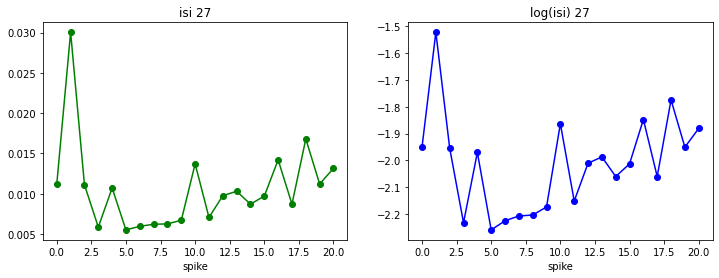

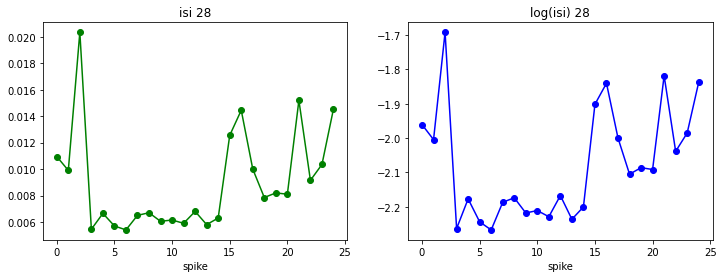

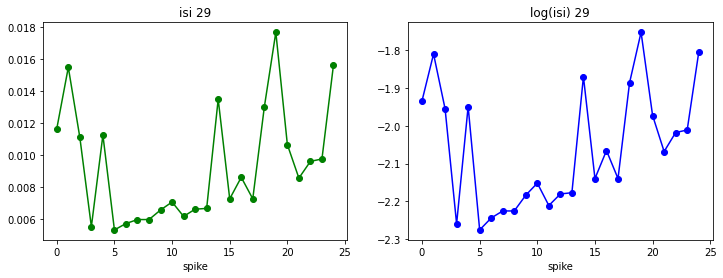

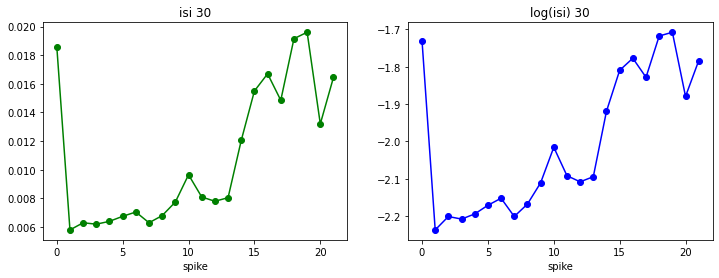

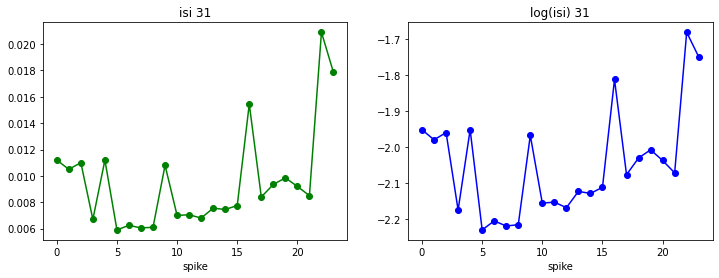

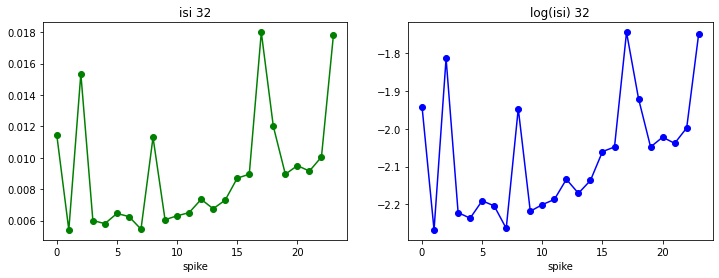

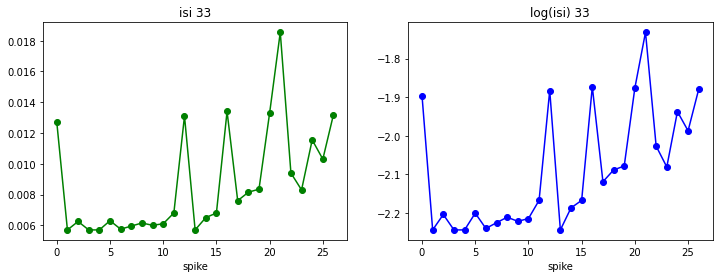

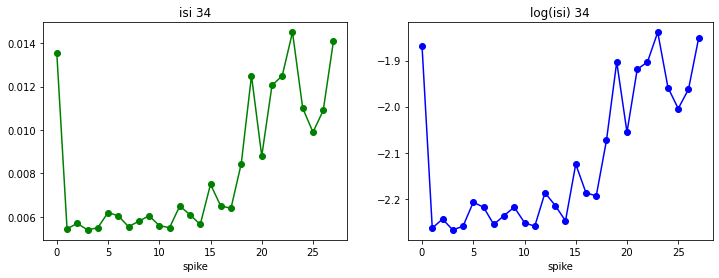

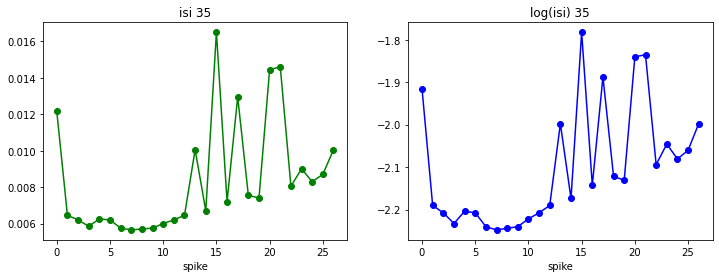

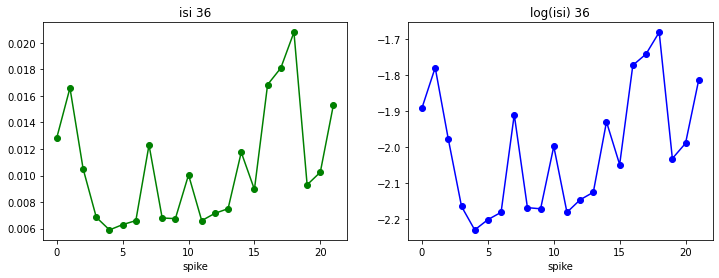

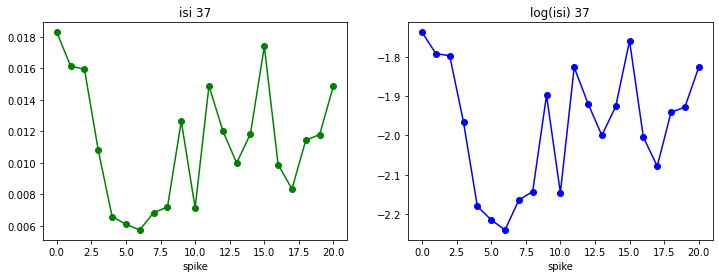

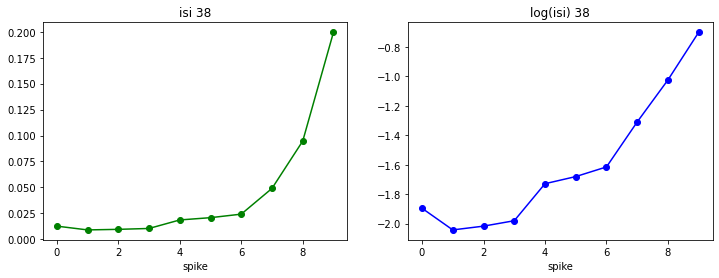

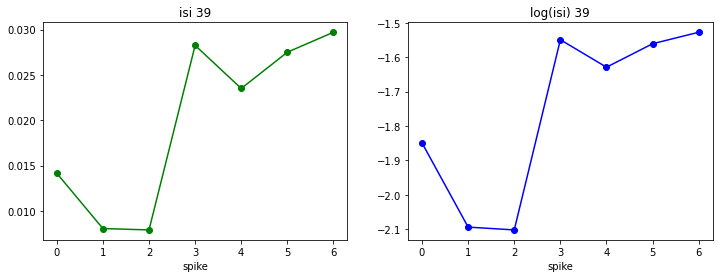

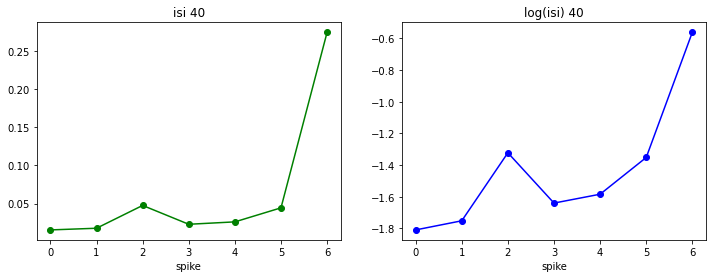

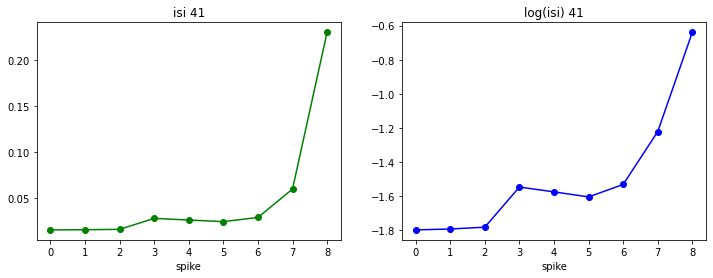

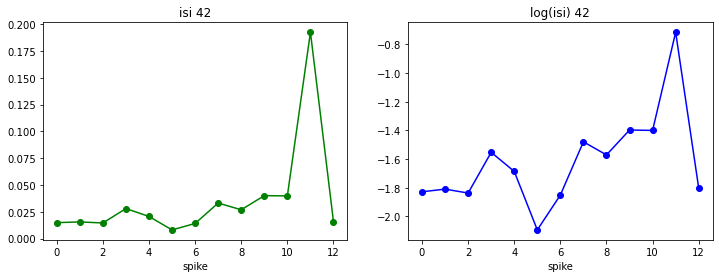

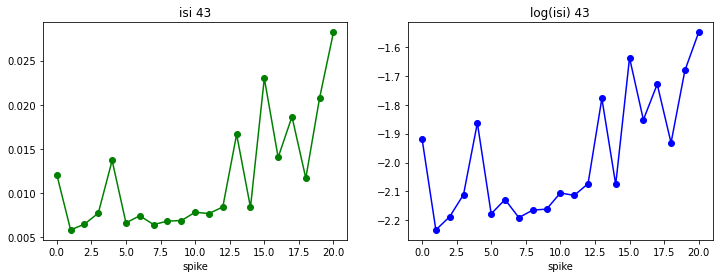

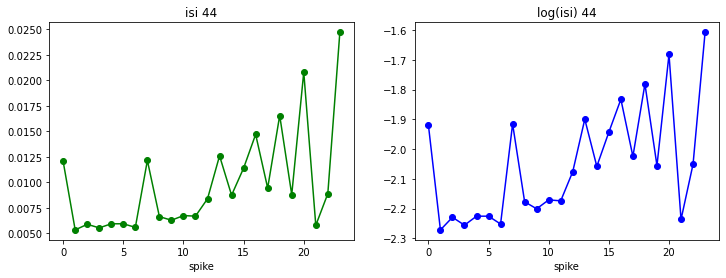

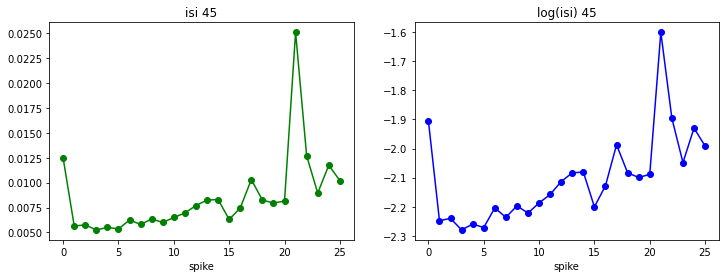

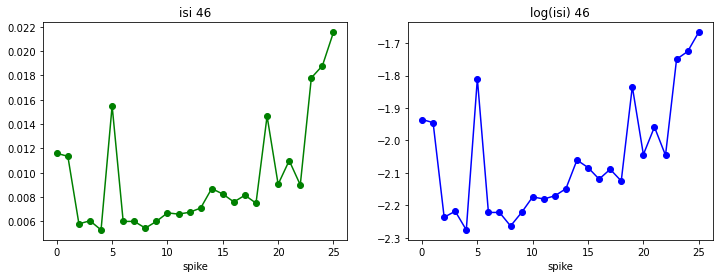

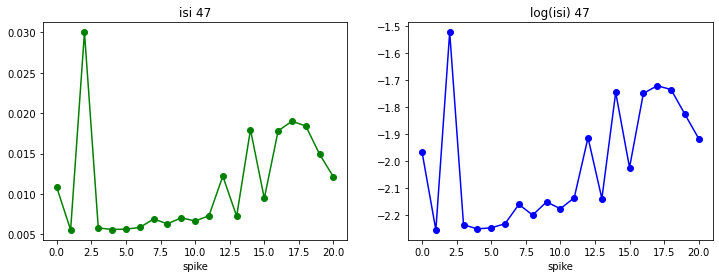

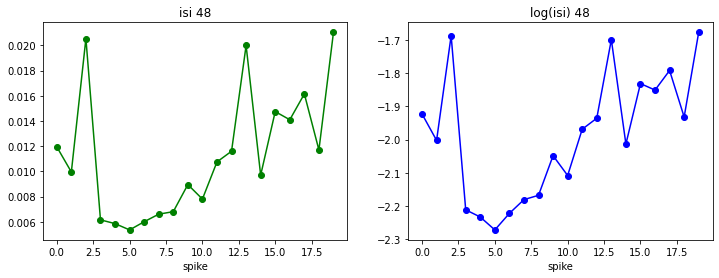

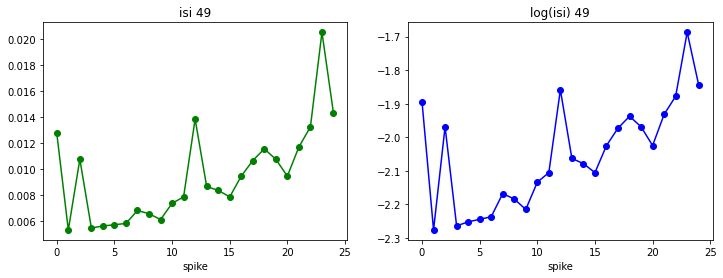

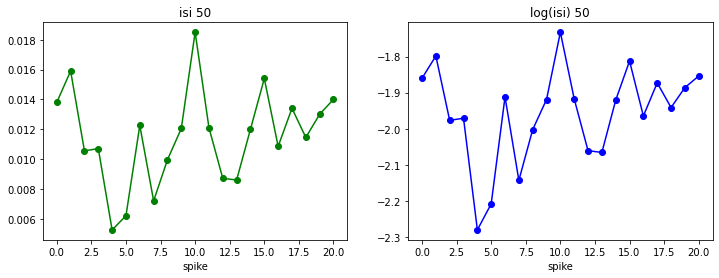

In [29]:
spikes = np.arange(1, 30, 1)
print(spikes)

for i in range(len(isi)):
    #print("number of spikes: " + str(len(isi[i])))
    #print(str(r2_isi[i]))#, str(mse_isi[i]))
    #print(r2_log_isi[i])#, str(mse_log_isi[i]))
    plot_isi(len(isi[i]), isi, log_isi, i)

# Create excel sheet with results

In [30]:
workbook = xlsxwriter.Workbook(ex_file_name + '.xlsx')
ws = workbook.add_worksheet(ex_file_name)
cell_format_b = workbook.add_format({'bg_color': '#b4c6e7'})
cell_format_w = workbook.add_format({'bg_color': 'white'})

In [31]:
### mechanical stimulus ###
ws.write(0, 0, "spike train", cell_format_w)
for i in range(num_trains):
    ws.write(0, i + 1, i, cell_format_w)

# write amplitude
ws.write(1, 0, "amplitude", cell_format_b)
#ws.write_row('B2', recording.mech_stimuli.amplitude)
for i in range(len(recording.mech_stimuli)):
    ws.write(1, i + 1, recording.mech_stimuli[i].amplitude, cell_format_b)
        
# write onset
ws.write(2, 0, "onset", cell_format_w)
i = 0
for m in recording.mech_stimuli:
    ws.write(2, i + 1, m.onset, cell_format_w)
    i += 1

# write duration
ws.write(3, 0, "duration", cell_format_b)
i = 0
for m in recording.mech_stimuli:
    ws.write(3, i + 1, m.duration, cell_format_b)
    i += 1
        
# write timings
ws.write(4, 0, "mech stim timings", cell_format_w)
i = 0
for m in recording.el_stimuli:
    ws.write(4, i + 1, m.timepoint, cell_format_w)
    i += 1
        
# write time to next stim
ws.write(5, 0, "time to next mechanical stimulus", cell_format_b)
i = 0
for m in range(len(recording.mech_stimuli)-1):
    ws.write(5, i + 1, recording.mech_stimuli[m].next_stim, cell_format_b)
    i += 1

In [32]:
### spike trains ###
# write number of spikes
ws.write(6, 0, "number of spikes", cell_format_w)
i = 0
for num in spike_counts:
    ws.write(6, i + 1, num, cell_format_w)
    i += 1
    
# write spike train duration
ws.write(7, 0, "spike train duration", cell_format_b)
i = 0
for dur in spike_train_duration:
    ws.write(7, i + 1, dur, cell_format_b)
    i += 1

# write electrical stimulus frequency
ws.write(8, 0, "electrical stimulus frequency", cell_format_w)
for i in range(len(el_stims)):
    ws.write(8, i + 1, el_stims[i].frequency, cell_format_w)
    
# write peak frequency (sliding window)
ws.write(9, 0, "sliding window peak frequency", cell_format_b)
ws.write_row(9, 1, peak_firing_freq_sw, cell_format_b)

# write peak frequency (5 highest instantaneous frequencies)
ws.write(10, 0, "peak frequency (5 max instantaneous frequencies)", cell_format_w)
ws.write_row(10, 1, peak_firing_freq_if, cell_format_w)

# write mean firing rate
ws.write(11, 0, "Mean firing rate", cell_format_b)
ws.write_row(11, 1, mean_firing_rate, cell_format_b)
    
# write spike times
ws.write(13, 0, "spike train times", cell_format_b)
for i in range(len(spike_train_times)):
    for j in range(len(spike_train_times[i])):
        ws.write(j + 13, i + 1, spike_train_times[i][j], cell_format_b)

# write ISI
ws.write(13 + max_spikes, 0, "ISI", cell_format_w)
for i in range(len(isi)):
    for j in range(len(isi[i])):
        ws.write(13 + max_spikes + j, i + 1, round(isi[i][j], 5), cell_format_w)

# write log(ISI)
ws.write(13 + (max_spikes*2), 0, "log(ISI)", cell_format_b)
for i in range(len(log_isi)):
    for j in range(len(log_isi[i])):
        ws.write(13 + (max_spikes*2) + j, i + 1, round(log_isi[i][j], 5), cell_format_b)
        
# write inst freq
ws.write(13 + (max_spikes*3), 0, "instantaneous frequencies", cell_format_w)
for i in range(len(inst_freq)):
    for j in range(len(inst_freq[i])):
        ws.write(13 + (max_spikes*3) + j, i + 1, round(inst_freq[i][j], 5), cell_format_w)

In [33]:
workbook.close()

# recreate the diagrams from the original paper

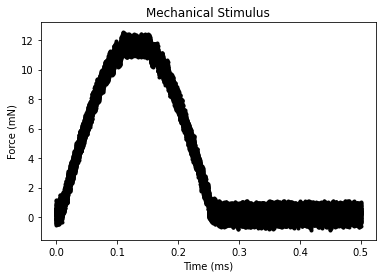

In [35]:
# try to plot m_signals
#x = np.array(range(0, 1000))
x = np.arange(0, 0.5, 0.0005)
y = m_signals[0]
#fig, (ax1) = plt.subplots(1, sharex = True)
#ax1.plot(x, m_signals[0], 'g-')
#ax1.set_ylabel('Peak firing frequency [1/s]')

# 500 ms
plt.title("Mechanical Stimulus")
plt.xlabel("Time (ms)")
plt.ylabel("Force (mN)")
for i, m in enumerate(m_signals):  
    plt.plot(x, m, color = "black", marker = ".", label = "Array elements")
#plt.legend()
plt.show()

In [37]:
# create times_separated for inst freqs
times_sp_inst = []
for i, val in enumerate(times_separated):
    times_sp_inst.append(val[1:])
for i in times_sp_inst:
    i = [x * 1000 for x in i]

In [78]:
def get_freq_color(freq):
    if freq < 0.2:
        return "grey"
    elif freq < 0.8:
        return "black"
    elif 1.9 < freq < 2.1:
        return "red"
    elif 3.9 < freq < 4.1:
        return "yellow"
    elif 4.9 < freq < 5.1:
        return "green"
    else:
        return "white"
    
def sliding_window_3(l):
    l_short = []
    for i, v in enumerate(l):
        if 0 < i < len(l) - 1:
            l_short.append((l[i-1]+l[i]+l[i+1])/3)
    return l_short

In [40]:
# plot inst freq with sliding window of 3
ifdf = pd.DataFrame({"if": inst_freq[0],
                     "times_sp": times_sp_inst[0]})

In [41]:
# create sliing window 3 lists
inst_freqs_sw = []
times_sw = []
for i,v in enumerate(inst_freq):
    inst_freqs_sw.append(sliding_window_3(inst_freq[i]))
    times_sw.append(sliding_window_3(times_sp_inst[i]))

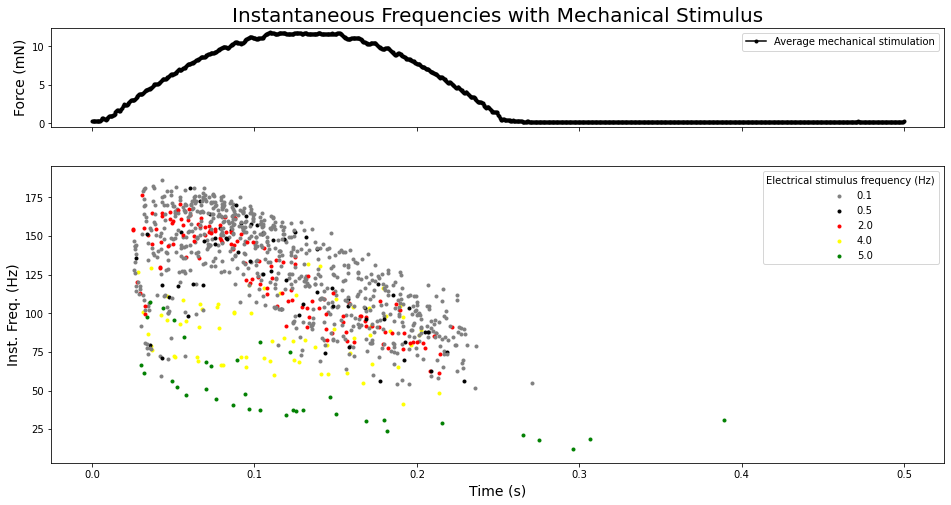

In [82]:
# plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, sharex = True, gridspec_kw={'height_ratios': [1, 3]})
ax1.set_title("Instantaneous Frequencies with Mechanical Stimulus", fontsize = 20)
ax2.set_ylabel("Inst. Freq. (Hz)", fontsize = 14) 
lc = 0 # frequency of last spike train
lcl = [] # list of patches for legend
freq_list = [] # list of frequencies already occurred
d = {} # dictionary for patches
for j, i in enumerate(inst_freq):
    freq = el_freqs[j]
    d["patch{0}".format(j)] = ax2.scatter(times_sw[j], inst_freqs_sw[j], color = get_freq_color(freq), marker = ".", label = str(freq))
    if not freq == lc and not freq in freq_list:
        lc = freq
        freq_list.append(freq)
        lcl.append(d["patch{0}".format(j)])
lcl.sort(key=lambda x: x.get_label())
ax2.legend(handles=lcl, title = "Electrical stimulus frequency (Hz)")

# mechanical stimulus
x = np.arange(0, 0.5, 0.0005)
y = m_signals[0]
ax2.set_xlabel("Time (s)", fontsize = 14)
ax1.set_ylabel("Force (mN)", fontsize = 14)
ax1.plot(x, np.average(m_signals, axis=0), color = "black", marker = ".", label = "Average mechanical stimulation")
ax1.legend()

fig.set_size_inches(16, 8)

for ax in fig.get_axes():
    ax.label_outer()

fig.savefig(ex_file_name + "_inst_freqs.png")
